# visualize results from probing tests


In [3]:
import sys
sys.path.append('../')
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.express.colors import qualitative
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import torch

In [4]:
def get_pile_unigram_distribution(file_path="/Users/jliu/workspace/RAG/datasets/src/pythia-unigrams.npy", pad_to_match_W_U=True, device="cuda", model_name="pythia-410m"): 
    
    unigram_count = np.load(file_path)

    if "pythia" in model_name:
        W_U_SIZE = 50304
        TRUE_VOCAB_SIZE = 50277
    elif "phi-2" in model_name: 
        W_U_SIZE = 51200
        TRUE_VOCAB_SIZE = 50295
    token_discrepancy = W_U_SIZE - TRUE_VOCAB_SIZE
    if pad_to_match_W_U:
        unigram_count = np.concatenate([unigram_count, [0] * token_discrepancy])

    unigram_distrib = unigram_count + 1 
    unigram_distrib = unigram_distrib / unigram_distrib.sum()
    unigram_distrib = torch.tensor(unigram_distrib, dtype=torch.float32).to(device)

    return unigram_distrib

def calculate_zipf_threshold(unigram_distrib, head_portion=0.3, error_threshold=0.5, plot=True):
    
    # Convert to numpy if tensor
    if torch.is_tensor(unigram_distrib):
        unigram_probs = unigram_distrib.cpu().numpy()
    else:
        unigram_probs = unigram_distrib
    
    # Make sure it's normalized
    if abs(unigram_probs.sum() - 1.0) > 1e-5:
        unigram_probs = unigram_probs / unigram_probs.sum()
    
    # Sort by frequency (descending)
    sorted_indices = np.argsort(-unigram_probs)
    sorted_probs = unigram_probs[sorted_indices]
    ranks = np.arange(1, len(sorted_probs) + 1)
    
    # Filter out zeros for log calculation
    nonzero_mask = sorted_probs > 0
    nonzero_ranks = ranks[nonzero_mask]
    nonzero_probs = sorted_probs[nonzero_mask]
    
    log_ranks = np.log(nonzero_ranks)
    log_probs = np.log(nonzero_probs)
    
    # Fit Zipf's law to the head of the distribution
    head_cutoff = int(len(nonzero_ranks) * head_portion)
    fit = stats.linregress(log_ranks[:head_cutoff], log_probs[:head_cutoff])
    alpha = -fit.slope
    
    # Predict token frequencies based on the fit
    predicted_log_probs = fit.slope * log_ranks + fit.intercept
    predicted_probs = np.exp(predicted_log_probs)
    
    # Calculate relative error between actual and predicted
    relative_error = np.abs(nonzero_probs - predicted_probs) / predicted_probs
    
    # Find where error exceeds the threshold
    deviation_indices = np.where(relative_error > error_threshold)[0]
    
    if len(deviation_indices) > 0:
        first_major_deviation = deviation_indices[0]
        threshold = nonzero_probs[first_major_deviation]
        deviation_rank = nonzero_ranks[first_major_deviation]
    else:
        print("No deviation found")
        threshold = np.percentile(nonzero_probs, 70)
        deviation_rank = None
    
    # Calculate percentage of tokens considered long-tail
    long_tail_count = (unigram_probs < threshold).sum()
    long_tail_percentage = long_tail_count / len(unigram_probs) * 100
    
    stats_dict = {
        'threshold': threshold,
        'alpha': alpha,
        'zipf_fit_slope': fit.slope,
        'zipf_fit_intercept': fit.intercept,
        'zipf_fit_r_value': fit.rvalue,
        'long_tail_token_count': long_tail_count,
        'long_tail_percentage': long_tail_percentage,
        'deviation_rank': deviation_rank
    }
    
    if plot:
        plt.figure(figsize=(12, 10))
        
        # Plot 1: Zipf distribution and fit
        plt.subplot(2, 1, 1)
        plt.loglog(nonzero_ranks, nonzero_probs, 'b.', markersize=2, alpha=0.5, label='Token frequencies')
        plt.loglog(nonzero_ranks, predicted_probs, 'r-', label=f'Zipf fit: α = {alpha:.2f}, R² = {fit.rvalue**2:.3f}')
        
        if deviation_rank is not None:
            plt.axvline(x=deviation_rank, color='g', linestyle='--', 
                        label=f'Deviation rank: {deviation_rank}')
        
        plt.axhline(y=threshold, color='g', linestyle='--',
                    label=f'Long-tail threshold: {threshold:.8f}')
        
        plt.title(f'Zipf Distribution of Token Frequencies\n{long_tail_count} tokens ({long_tail_percentage:.1f}% of vocab) in long tail')
        plt.xlabel('Token Rank')
        plt.ylabel('Probability')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Plot 2: Relative error
        plt.subplot(2, 1, 2)
        plt.semilogx(nonzero_ranks, relative_error, 'b-', alpha=0.7)
        plt.axhline(y=error_threshold, color='r', linestyle='--', 
                    label=f'Error threshold: {error_threshold}')
        
        if deviation_rank is not None:
            plt.axvline(x=deviation_rank, color='g', linestyle='--', 
                        label=f'First major deviation: rank {deviation_rank}')
        
        plt.title('Relative Error between Actual and Zipf-predicted Frequencies')
        plt.xlabel('Token Rank')
        plt.ylabel('Relative Error')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        # Save plot
        plt.savefig(f'zipf_threshold_analysis_{threshold:.8f}.png', dpi=300)
        plt.show()
    
    return threshold, stats_dict

In [24]:
import numpy as np
import torch
import typing as t
from scipy import stats
import matplotlib.pyplot as plt

class ZipfThresholdAnalyzer:
    """
    Advanced analyzer for identifying long-tail tokens with improved robustness.
    """
    def __init__(
        self, 
        head_portion: float = 0.3, 
        error_threshold: float = 0.5,
        min_tokens_threshold: int = 3,
        percentile_fallback: float = 90.0
    ):
        """
        Initialize Zipf threshold analyzer with configurable parameters.
        """
        self.head_portion = head_portion
        self.error_threshold = error_threshold
        self.min_tokens_threshold = min_tokens_threshold
        self.percentile_fallback = percentile_fallback
    
    def _preprocess_distribution(
        self, 
        unigram_distrib: np.ndarray | torch.Tensor
    ) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
        """
        Preprocess the input distribution for analysis.
        """
        # Normalize and convert to numpy
        if torch.is_tensor(unigram_distrib):
            unigram_probs = unigram_distrib.cpu().numpy()
        else:
            unigram_probs = np.asarray(unigram_distrib)
        
        # Ensure probability distribution sums to 1
        unigram_probs = unigram_probs / unigram_probs.sum()
        
        # Sort probabilities in descending order
        sorted_indices = np.argsort(-unigram_probs)
        sorted_probs = unigram_probs[sorted_indices]
        ranks = np.arange(1, len(sorted_probs) + 1)
        
        return sorted_probs, ranks, sorted_indices
    
    def calculate_threshold(
        self, 
        unigram_distrib: np.ndarray | torch.Tensor,
        verbose: bool = False
    ) -> tuple[float, dict[str, t.Any]]:
        """
        Calculate long-tail threshold with improved robustness.
        
        Args:
            unigram_distrib: Distribution of token probabilities
            verbose: Enable detailed logging and visualization
        
        Returns:
            Tuple of (threshold, statistics dictionary)
        """
        # Preprocess distribution
        sorted_probs, ranks, sorted_indices = self._preprocess_distribution(unigram_distrib)
        
        # Filter out zero probabilities for log calculations
        nonzero_mask = sorted_probs > 0
        nonzero_ranks = ranks[nonzero_mask]
        nonzero_probs = sorted_probs[nonzero_mask]
        
        # Compute log ranks and probabilities
        log_ranks = np.log(nonzero_ranks)
        log_probs = np.log(nonzero_probs)
        
        # Validate sufficient data for analysis
        if len(nonzero_ranks) < self.min_tokens_threshold:
            raise ValueError(
                f"Insufficient non-zero tokens. "
                f"Need at least {self.min_tokens_threshold}, "
                f"found {len(nonzero_ranks)}"
            )
        
        # Fit Zipf's law to the head of the distribution
        head_cutoff = max(2, int(len(nonzero_ranks) * self.head_portion))
        
        try:
            fit = stats.linregress(log_ranks[:head_cutoff], log_probs[:head_cutoff])
        except Exception as e:
            raise ValueError(f"Error fitting Zipf's law: {e}")
        
        # Predict token frequencies based on the fit
        predicted_log_probs = fit.slope * log_ranks + fit.intercept
        predicted_probs = np.exp(predicted_log_probs)
        
        # Calculate relative error between actual and predicted
        relative_error = np.abs(nonzero_probs - predicted_probs) / predicted_probs
        
        # Improved threshold detection
        # 1. Look for consistent deviation beyond error threshold
        consistent_deviation_mask = relative_error > self.error_threshold
        
        if np.sum(consistent_deviation_mask) > 0:
            # Find the first point of consistent deviation
            long_tail_start_index = np.argmax(consistent_deviation_mask)
            threshold = float(nonzero_probs[long_tail_start_index])
            deviation_rank = int(nonzero_ranks[long_tail_start_index])
        else:
            # Fallback to percentile-based threshold
            threshold = float(np.percentile(nonzero_probs, self.percentile_fallback))
            deviation_rank = None
        
        # Calculate long-tail statistics
        long_tail_mask = sorted_probs < threshold
        long_tail_count = int(long_tail_mask.sum())
        long_tail_percentage = long_tail_count / len(sorted_probs) * 100
        
        # Compile detailed statistics
        stats_dict: dict[str, t.Any] = {
            "threshold": threshold,
            "alpha": -fit.slope,
            "zipf_fit_slope": fit.slope,
            "zipf_fit_intercept": fit.intercept,
            "zipf_fit_r_value": fit.rvalue,
            "long_tail_token_count": long_tail_count,
            "long_tail_percentage": long_tail_percentage,
            "deviation_rank": deviation_rank,
            "relative_errors": relative_error.tolist(),
        }
        
        # Optional visualization
        if verbose:
            self._visualize_threshold(
                nonzero_ranks, 
                nonzero_probs, 
                log_ranks, 
                log_probs, 
                fit, 
                head_cutoff, 
                threshold, 
                relative_error
            )
        
        return threshold, stats_dict
    
    def _visualize_threshold(
        self, 
        nonzero_ranks: np.ndarray, 
        nonzero_probs: np.ndarray, 
        log_ranks: np.ndarray, 
        log_probs: np.ndarray, 
        fit: t.Any, 
        head_cutoff: int, 
        threshold: float, 
        relative_error: np.ndarray
    ):
        """
        Create detailed visualizations of the threshold analysis.
        
        Args:
            Various statistical parameters computed during threshold analysis
        """
        plt.figure(figsize=(15, 5))
        
        # Log-Log Distribution Plot
        plt.subplot(1, 3, 1)
        plt.scatter(log_ranks, log_probs, label='Actual', alpha=0.7)
        plt.plot(
            log_ranks[:head_cutoff], 
            fit.slope * log_ranks[:head_cutoff] + fit.intercept, 
            color='red', 
            label='Zipf Fit'
        )
        plt.title("Log-Log Distribution")
        plt.xlabel("Log Rank")
        plt.ylabel("Log Probability")
        plt.legend()
        
        # Probability Distribution Plot
        plt.subplot(1, 3, 2)
        plt.bar(range(len(nonzero_probs)), nonzero_probs)
        plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
        plt.title("Probability Distribution")
        plt.xlabel("Rank")
        plt.ylabel("Probability")
        plt.legend()
        
        # Relative Error Plot
        plt.subplot(1, 3, 3)
        plt.plot(nonzero_ranks, relative_error, label='Relative Error')
        plt.axhline(
            y=self.error_threshold, 
            color='r', 
            linestyle='--', 
            label='Error Threshold'
        )
        plt.title("Relative Error by Rank")
        plt.xlabel("Rank")
        plt.ylabel("Relative Error")
        plt.legend()
        
        plt.tight_layout()
        plt.show()


In [45]:
from __future__ import annotations

import numpy as np
import torch
import typing as t
import matplotlib.pyplot as plt
from scipy import stats

class ZipfThresholdAnalyzer:
    
    def __init__(
        self, 
        head_portion: float = 0.2,  # Modified to 20% for tail analysis
        tail_threshold: float = 0.8,  # New parameter for tail region
        residual_significance_threshold: float = 1.5,  # Threshold for identifying anomalous words
        min_tokens_threshold: int = 10  # Increased for more robust analysis
    ):
        """Initialize Zipf threshold analyzer with configurable parameters."""
        self.head_portion = head_portion
        self.tail_threshold = tail_threshold
        self.residual_significance_threshold = residual_significance_threshold
        self.min_tokens_threshold = min_tokens_threshold

    def _preprocess_distribution(
        self, 
        unigram_distrib: np.ndarray | torch.Tensor
    ) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
        """Preprocess the input distribution for Zipf law analysis."""
        # Normalize and convert to numpy
        if torch.is_tensor(unigram_distrib):
            unigram_probs = unigram_distrib.cpu().numpy()
        else:
            unigram_probs = np.asarray(unigram_distrib)
        
        # Ensure probability distribution sums to 1
        unigram_probs = unigram_probs / unigram_probs.sum()
        
        # Sort probabilities in descending order
        sorted_indices = np.argsort(-unigram_probs)
        sorted_probs = unigram_probs[sorted_indices]
        ranks = np.arange(1, len(sorted_probs) + 1)
        
        return sorted_probs, ranks, sorted_indices


    
    def find_elbow_point(
        self,
        log_ranks: np.ndarray,
        log_probs: np.ndarray,
        window_size: int = 2000,
        threshold_multiplier: float = 3.0,
        min_rank_percentile: float = 0.5
    ) -> dict[str, t.Any]:
    
        # We need enough points for a meaningful analysis
        if len(log_ranks) < window_size * 3:
            return {"elbow_detected": False, "message": "Not enough data points for elbow detection"}
        
        # Calculate first derivatives (slopes) using sliding windows
        derivatives = []
        indices = []
        # Skip the very head of the distribution as it might have its own variations
        min_rank_idx = max(int(len(log_ranks) * min_rank_percentile), window_size * 2)
        
        for i in range(min_rank_idx, len(log_ranks) - window_size):
            # Calculate slope in the current window
            window_fit = stats.linregress(
                log_ranks[i:i+window_size], 
                log_probs[i:i+window_size]
            )
            derivatives.append(window_fit.slope)
            indices.append(i)
        
        derivatives = np.array(derivatives)
        
        # Compute differences between adjacent slopes to find rapid changes
        slope_changes = np.abs(np.diff(derivatives))
        
        # Detect significant changes (beyond several standard deviations)
        mean_change = np.mean(slope_changes)
        std_change = np.std(slope_changes)
        threshold = mean_change + threshold_multiplier * std_change
        
        # Find points exceeding the threshold
        significant_changes = np.where(slope_changes > threshold)[0]
        
        if len(significant_changes) == 0:
            return {"elbow_detected": False, "message": "No significant elbow point detected"}
        
        # Find the most significant change
        max_change_idx = significant_changes[np.argmax(slope_changes[significant_changes])]
        elbow_idx = indices[max_change_idx + 1]  # +1 because of np.diff
        
        # Get actual rank and probability at the elbow point
        elbow_rank = np.exp(log_ranks[elbow_idx])
        elbow_prob = np.exp(log_probs[elbow_idx])
        
        return {
            "elbow_detected": True,
            "elbow_rank": int(elbow_rank),
            "elbow_probability": elbow_prob,
            "elbow_log_rank": log_ranks[elbow_idx],
            "elbow_log_probability": log_probs[elbow_idx],
            "elbow_index": elbow_idx,
            "slope_before": derivatives[max_change_idx],
            "slope_after": derivatives[max_change_idx + 1]
        }


        
    def analyze_zipf_anomalies(
        self, 
        unigram_distrib: np.ndarray | torch.Tensor,
        detect_elbow: bool = True,
        verbose: bool = False
    ) -> dict[str, t.Any]:
        """Analyze Zipf law distribution and identify anomalous words."""
        # Preprocess distribution
        sorted_probs, ranks, sorted_indices = self._preprocess_distribution(unigram_distrib)
        # Validate sufficient data
        if len(sorted_probs) < self.min_tokens_threshold:
            raise ValueError(
                f"Insufficient tokens. "
                f"Need at least {self.min_tokens_threshold}, "
                f"found {len(sorted_probs)}"
            )
        # Fit Zipf's law to the head of the distribution
        head_cutoff = max(2, int(len(sorted_probs) * self.head_portion))
        tail_start = max(2, int(len(sorted_probs) * self.tail_threshold))
        # Take log of ranks and probabilities
        log_ranks = np.log(ranks)
        log_probs = np.log(sorted_probs)
        # Fit Zipf law to the head (power law)
        head_fit = stats.linregress(log_ranks[:head_cutoff], log_probs[:head_cutoff])
        
        # Predict probabilities for the entire distribution
        predicted_log_probs = head_fit.slope * log_ranks + head_fit.intercept
        predicted_probs = np.exp(predicted_log_probs)
        
        # Calculate residuals for the tail region
        tail_residuals = log_probs[tail_start:] - (head_fit.slope * log_ranks[tail_start:] + head_fit.intercept)
        
        # Compute residual statistics
        residual_mean = np.mean(tail_residuals)
        residual_std = np.std(tail_residuals)
        
        # Identify anomalous words in the tail
        z_scores = (tail_residuals - residual_mean) / residual_std
        anomalous_mask = z_scores > self.residual_significance_threshold
        
        # Prepare results
        results = {
            'zipf_alpha': -head_fit.slope,  # Power law exponent
            'zipf_fit_r_value': head_fit.rvalue,
            'tail_residual_mean': residual_mean,
            'tail_residual_std': residual_std,
            'tail_start_rank': tail_start
        }
        
        # Detect elbow point if requested
        elbow_info = None
        if detect_elbow:
            elbow_info = self.find_elbow_point(log_ranks, log_probs)
            results['elbow_info'] = elbow_info
        
        # Optional visualization
        if verbose:
            self._visualize_zipf_analysis(
                log_ranks, log_probs, head_fit, 
                head_cutoff, tail_start, 
                tail_residuals, z_scores,
                elbow_info
            )
        
        return results

    def _visualize_zipf_analysis(
        self, 
        log_ranks: np.ndarray, 
        log_probs: np.ndarray, 
        head_fit: t.Any, 
        head_cutoff: int, 
        tail_start: int, 
        tail_residuals: np.ndarray,
        z_scores: np.ndarray,
        elbow_info: dict[str, t.Any] = None
    ):
    
        plt.figure(figsize=(15, 5))
        
        # Log-Log Distribution Plot
        plt.subplot(1, 3, 1)
        plt.scatter(log_ranks, log_probs, label='Actual', alpha=0.7)
        plt.plot(
            log_ranks[:head_cutoff], 
            head_fit.slope * log_ranks[:head_cutoff] + head_fit.intercept, 
            color='red', 
            label='Zipf Fit (Head)'
        )
        
        # Mark the elbow point if detected
        if elbow_info and elbow_info.get("elbow_detected", False):
            elbow_idx = elbow_info["elbow_index"]
            plt.scatter(
                log_ranks[elbow_idx], 
                log_probs[elbow_idx], 
                color='green', 
                s=100, 
                marker='X', 
                label=f'Elbow Point (Rank {int(np.exp(log_ranks[elbow_idx]))})'
            )
        
        plt.title("Log-Log Distribution")
        plt.xlabel("Log Rank")
        plt.ylabel("Log Probability")
        plt.legend()
        
        # Tail Residuals Plot
        plt.subplot(1, 3, 2)
        plt.scatter(
            log_ranks[tail_start:], 
            tail_residuals, 
            label='Tail Residuals', 
            alpha=0.7
        )
        
        # Mark the elbow point on the residuals plot if in range
        if elbow_info and elbow_info.get("elbow_detected", False):
            elbow_idx = elbow_info["elbow_index"]
            if elbow_idx >= tail_start:
                elbow_residual_idx = elbow_idx - tail_start
                plt.scatter(
                    log_ranks[elbow_idx], 
                    tail_residuals[elbow_residual_idx], 
                    color='green', 
                    s=100, 
                    marker='X', 
                    label='Elbow Point'
                )
        
        plt.title("Tail Residuals")
        plt.xlabel("Log Rank")
        plt.ylabel("Residual")
        plt.legend()


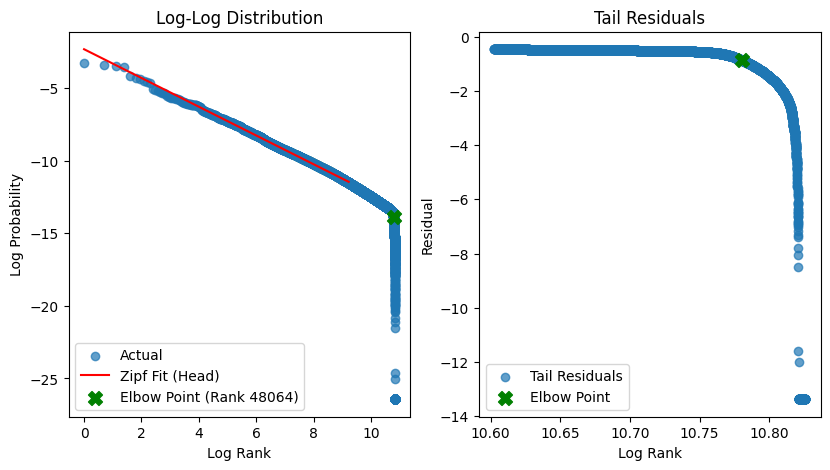

In [46]:
file_path="/Users/jliu/workspace/RAG/datasets/src/pythia-unigrams.npy"
unigram_distrib = get_pile_unigram_distribution(file_path, pad_to_match_W_U=True, device="mps", model_name="pythia-410m") 

analyzer = ZipfThresholdAnalyzer()
results = analyzer.analyze_zipf_anomalies(unigram_distrib, verbose=True)
    

In [47]:
results

{'zipf_alpha': 0.990593182080885,
 'zipf_fit_r_value': -0.9992680599391592,
 'tail_residual_mean': -1.0914550156220864,
 'tail_residual_std': 2.0551838956630157,
 'tail_start_rank': 40243,
 'elbow_info': {'elbow_detected': True,
  'elbow_rank': 48064,
  'elbow_probability': 9.445667e-07,
  'elbow_log_rank': 10.780309540499916,
  'elbow_log_probability': -13.8725395,
  'elbow_index': 48064,
  'slope_before': -75.86141209317837,
  'slope_after': -76.6357621200478}}

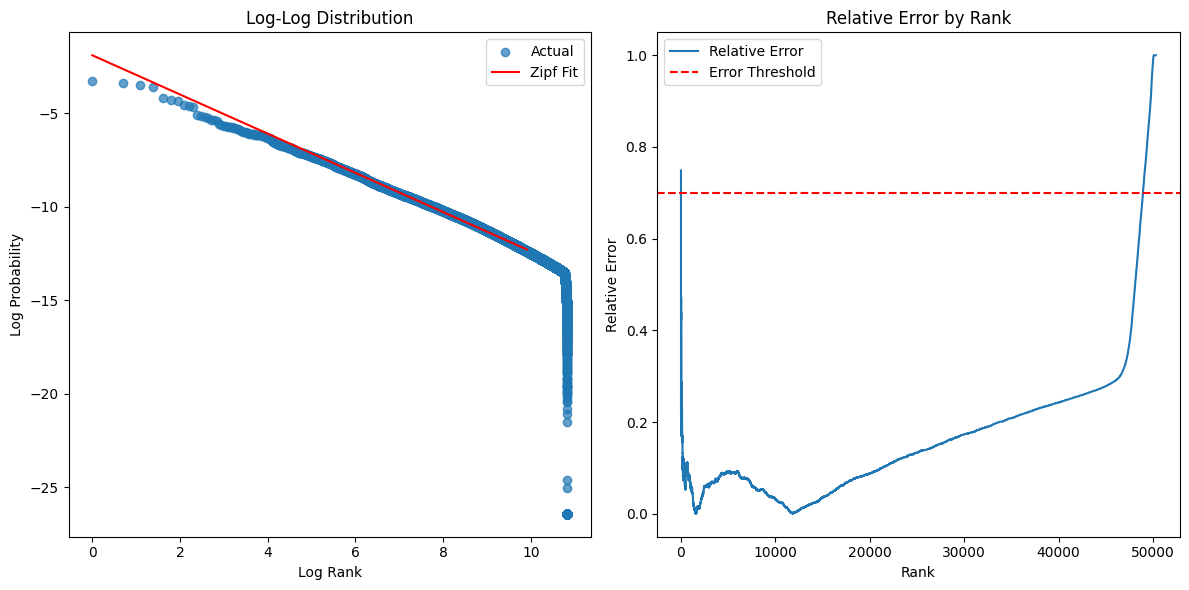

Detailed Zipf Threshold Analysis:
threshold: 0.0382516086101532
alpha: 1.0494566933329075
zipf_fit_slope: -1.0494566933329075
zipf_fit_intercept: -1.8825463849180988
zipf_fit_r_value: -0.997970929910798
long_tail_token_count: 50303
long_tail_percentage: 99.998012086514
deviation_rank: 1
relative_errors: [0.7486787504491823, 0.5434619070725849, 0.3569364749617597, 0.21925959594632236, 0.4388047326876983, 0.417944723217174, 0.3485333447864128, 0.3810953901180868, 0.32115955891230175, 0.29833372338476566, 0.500241063340378, 0.46700223914094013, 0.4715702773879012, 0.44613766568213475, 0.4556575608985659, 0.4378902319276697, 0.42154754750919843, 0.47241403672373344, 0.4633854475511696, 0.46030950606170096, 0.45334681483087125, 0.43998671725303157, 0.41857275576831776, 0.39320805128597597, 0.4052929458347229, 0.38100418645243933, 0.3711388993004637, 0.3784655864474011, 0.3839917097050707, 0.3899882934243223, 0.38120922288580567, 0.3716646798402288, 0.366821202355426, 0.36542085945771374, 0.

In [31]:
file_path="/Users/jliu/workspace/RAG/datasets/src/pythia-unigrams.npy"
unigram_distrib = get_pile_unigram_distribution(file_path, pad_to_match_W_U=True, device="mps", model_name="pythia-410m") 
threshold, stats_dict = calculate_zipf_threshold(unigram_distrib, head_portion=0.4, error_threshold=0.7,verbose=True)

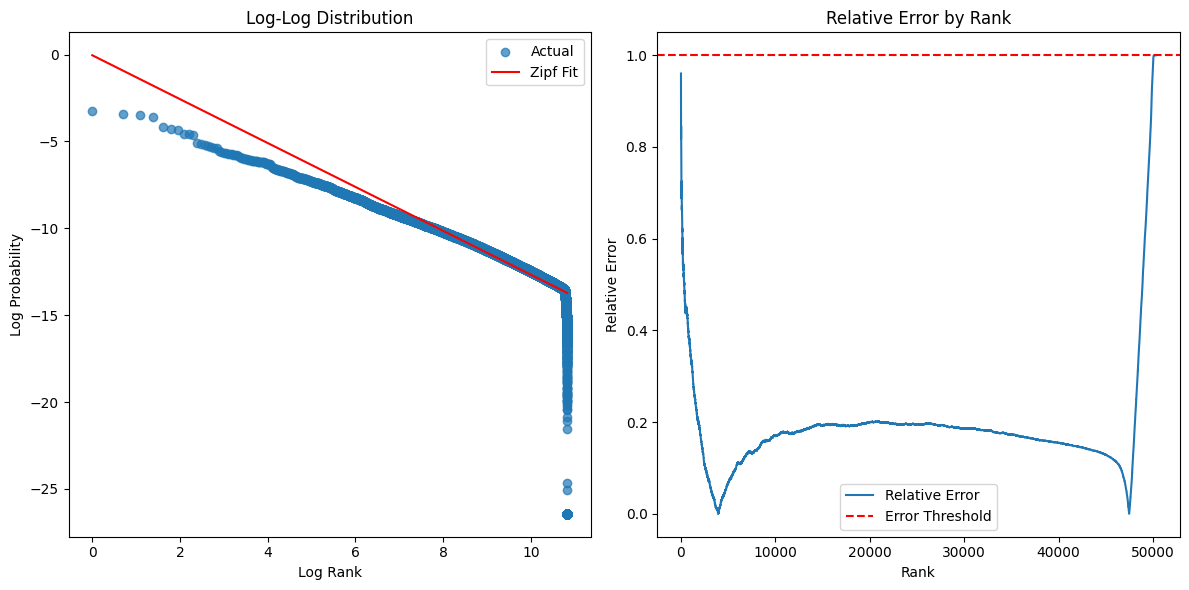

Detailed Zipf Threshold Analysis:
threshold: 6.039042091288133e-06
alpha: 1.2631814570807858
zipf_fit_slope: -1.2631814570807858
zipf_fit_intercept: -0.03991512238991213
zipf_fit_r_value: -0.797262059841359
long_tail_token_count: 35213
long_tail_percentage: 70.0003975826972
deviation_rank: None
relative_errors: [0.9601906926906273, 0.9161370769823733, 0.8711804093469702, 0.8336827884731703, 0.8746118168995992, 0.864783455425261, 0.8435894723715477, 0.8471055143941106, 0.8280237905537667, 0.8181929256074179, 0.867843847934216, 0.8564085596459194, 0.8551828728761665, 0.8457897696489743, 0.8461889871712551, 0.8389625808953292, 0.8321194117741588, 0.8450000841211942, 0.8405152478226179, 0.8378329907076825, 0.8340190294126602, 0.8282634600203612, 0.8199945110243166, 0.8104252282659923, 0.8125726786053115, 0.8032757189660422, 0.7985218175729742, 0.7993153761317456, 0.7996023455263651, 0.8001100445403277, 0.7958073204691472, 0.791246047480426, 0.7882488354881924, 0.7864221686578131, 0.7842581

In [23]:
file_path="/Users/jliu/workspace/RAG/datasets/src/pythia-unigrams.npy"
unigram_distrib = get_pile_unigram_distribution(file_path, pad_to_match_W_U=True, device="mps", model_name="pythia-410m") 
threshold, stats_dict = calculate_zipf_threshold(unigram_distrib, head_portion=1, error_threshold=1,verbose=True)

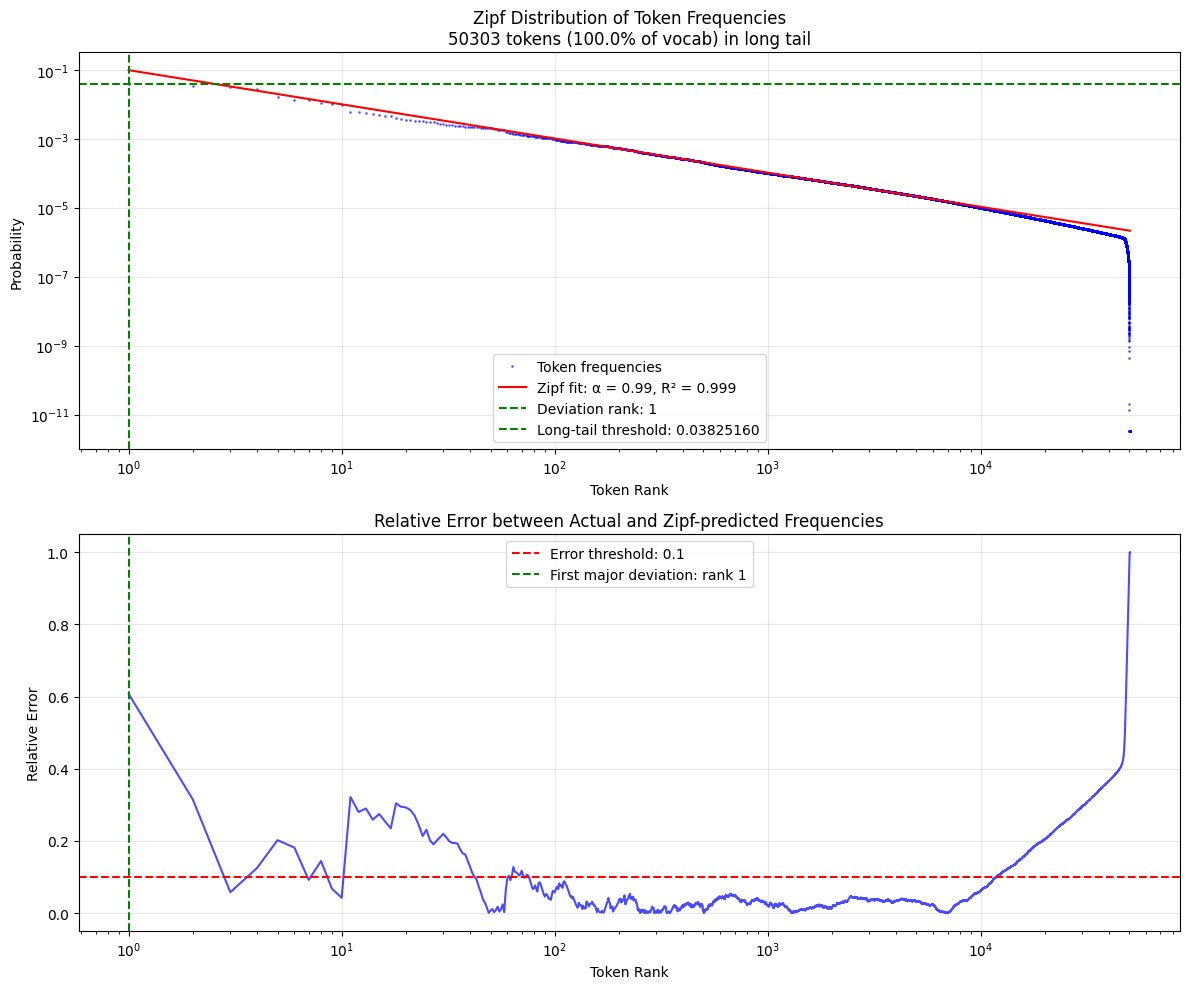

In [16]:
file_path="/Users/jliu/workspace/RAG/datasets/src/pythia-unigrams.npy"
unigram_distrib = get_pile_unigram_distribution(file_path, pad_to_match_W_U=True, device="mps", model_name="pythia-410m") 
threshold, stats_dict = calculate_zipf_threshold(unigram_distrib, head_portion=0.2, error_threshold=0.1, plot=True)

In [3]:
def load_result(
    model_name:str,
    dataset:str = 'stas/c4-en-10k',
    data_range_start:int = 0,
    data_range_end:int = 100,
    k = 10
    ):
    save_path = f'./{output_dir}/{model_name}/unigram/{dataset.replace("/","_")}_{data_range_start}-{data_range_end}/k{k}.feather'
    final_df = pd.read_feather(save_path)
    # %%
    final_df['delta_loss'] = final_df['loss_post_ablation'] - final_df['loss']
    final_df['delta_loss_with_frozen_unigram'] = final_df['loss_post_ablation_with_frozen_unigram'] - final_df['loss']
    final_df['abs_delta_loss_post_ablation'] = np.abs(final_df['loss_post_ablation'] - final_df['loss'])
    final_df['abs_delta_loss_post_ablation_with_frozen_unigram'] = np.abs(final_df['loss_post_ablation_with_frozen_unigram'] - final_df['loss'])
    final_df['delta_entropy'] = final_df['entropy_post_ablation'] - final_df['entropy']
    if 'kl_divergence_before' in final_df.columns:
        print('kl_divergence_before found')
        final_df['kl_from_unigram_diff'] = final_df['kl_divergence_after'] - final_df['kl_divergence_before']
        final_df['kl_from_unigram_diff_with_frozen_unigram'] = final_df['kl_divergence_after_frozen_unigram'] - final_df['kl_divergence_before']
        final_df['abs_kl_from_unigram_diff'] = final_df['kl_from_unigram_diff'].abs()
    final_df['abs_kl_from_unigram_diff'] = final_df['kl_from_unigram_diff'].abs()

    
    return final_df 

In [16]:
def select_top_token_frequency_neurons(
    final_df: pd.DataFrame, 
    unigram_kl_threshold: float = 2.0, 
    unigram_mediation_threshold: float = 0.5, 
    top_n: int = 10
) -> dict[str, list[str]]:
    """
    Correctly select top token frequency neurons based on multiple criteria.
    """
    # Calculate the mediation effect
    final_df['mediation_effect'] = (
        1 - final_df['abs_delta_loss_post_ablation_with_frozen_unigram'] 
        / final_df['abs_delta_loss_post_ablation']
    )

    '''
    # Filter neurons based on KL divergence and mediation effect
    filtered_neurons = final_df[
        (final_df['abs_kl_from_unigram_diff'] > unigram_kl_threshold) &
        (final_df['mediation_effect'] > unigram_mediation_threshold)
    ]

    # Rank neurons by their KL divergence and mediation effect
    
    ranked_neurons = filtered_neurons.sort_values(
        by=['abs_kl_from_unigram_diff', 'mediation_effect'], 
        ascending=False
    )

    ranked_neurons = filtered_neurons.sort_values(
        by='mediation_effect', 
        ascending=False
    )
    '''
    ranked_neurons = final_df.sort_values(
        by='mediation_effect', 
        ascending=False
    )
    
    # Select top N neurons, preserving the original sorting
    #top_neurons = ranked_neurons['component_name'].head(top_n).tolist()
    top_neurons = final_df['component_name'].head(top_n).tolist()
    return {
        model_name: top_neurons
    }

def aggregate_result(final_df:pd.DataFrame,unigram_neurons_dict:dict)->pd.DataFrame:

    if len(unigram_neurons_dict)>0:
        unigram_neurons = unigram_neurons_dict.get(model_name, [])
        final_df['is_unigram'] = final_df['component_name'].isin(unigram_neurons).astype(bool)
        
    columns_to_aggregate =list(final_df.columns[8:]) + ['loss']
    print(columns_to_aggregate)
    agg_results = final_df[columns_to_aggregate].groupby('component_name').mean().reset_index()

    # make scatter plot of delta_loss and delta_loss_with_frozen_unigram for each neuron
    agg_results['delta_loss-delta_loss_with_frozen_unigram'] = agg_results['delta_loss'] - agg_results['delta_loss_with_frozen_unigram']
    agg_results['abs_delta_loss-abs_delta_loss_with_frozen_unigram'] = agg_results['abs_delta_loss_post_ablation'] - agg_results['abs_delta_loss_post_ablation_with_frozen_unigram']
    # %%
    # make scatter plot of delta_loss and delta_loss_with_frozen_unigram for each neuron
    agg_results['delta_loss-delta_loss_with_frozen_unigram'] = agg_results['delta_loss'] - agg_results['delta_loss_with_frozen_unigram']
    agg_results['abs_delta_loss-abs_delta_loss_with_frozen_unigram'] = agg_results['abs_delta_loss_post_ablation'] - agg_results['abs_delta_loss_post_ablation_with_frozen_unigram']
    agg_results['1-abs_delta_loss_with_frozen_unigram/abs_delta_loss'] = 1 - agg_results['abs_delta_loss_post_ablation_with_frozen_unigram'] / agg_results['abs_delta_loss_post_ablation']

    return agg_results
    
def plot_top_token_frequency_neurons(
    agg_results: pd.DataFrame, 
    unigram_neurons: list[str], 
    model_name: str
):  # Consider specifying the exact return type of your plotting library
    """
    Create a scatter plot highlighting top token frequency neurons.

    Args:
        agg_results: Aggregated results DataFrame
        unigram_neurons: List of top token frequency neuron names
        model_name: Name of the model being analyzed

    Returns:
        Plotly figure object
    """
    

    # Prepare neuron type column
    conditions = [(agg_results['is_unigram'] == True)]
    choices = ['Token Frequency']
    agg_results['Neuron Type'] = np.select(conditions, choices, default='Normal')

    # Define axes and color mapping
    x_axis = '1-abs_delta_loss_with_frozen_unigram/abs_delta_loss'
    y_axis = 'abs_kl_from_unigram_diff'
    tf_color = qualitative.Plotly[2]

    # Create scatter plot
    fig = px.scatter(
        agg_results, 
        y=y_axis, 
        x=x_axis, 
        hover_data=['component_name'], 
        color='Neuron Type', 
        color_discrete_map={
            'Normal': qualitative.Plotly[0], 
            'Entropy': qualitative.Plotly[1], 
            'Token Frequency': tf_color
        }
    )

    # Add text labels for top token frequency neurons
    entropy_neuron_indices = [
        int(neuron.split('.')[1]) for neuron in unigram_neurons
    ]
    
    for neuron_index in entropy_neuron_indices:
        entropy_df = agg_results[
            agg_results['component_name'] == f'23.{neuron_index}'
        ]
        fig.add_trace(
            go.Scatter(
                x=entropy_df[x_axis]-0.01, 
                y=entropy_df[y_axis], 
                mode='text', 
                text=str(neuron_index), 
                textposition='bottom left', 
                showlegend=False, 
                textfont=dict(color=tf_color)
            )
        )

    # Customize layout
    fig.update_layout(
        legend=dict(
            orientation='h',
            yanchor='bottom',
            y=-0.6,
            xanchor='right',
            x=0.9
        ),
        title=f'(c) Top Token Frequency Neurons',
        margin=dict(l=0, r=3, t=30, b=0),
        width=350, 
        height=275,
        title_font_size=16
    )

    # Update axes
    fig.update_yaxes(title_text='Avg. |Δ D<sub>KL</sub>(P<sub>model</sub>||P<sub>freq</sub>)|')
    fig.update_xaxes(
        title_text='1 - DE<sub>freq</sub>/TE',
        range=[-0.25, 0.62]
    )

    return fig



In [31]:
def select_token_frequency_neurons(
    agg_results: pd.DataFrame, 
    x_threshold: float = 0.2,  # Threshold for indirect effect
    y_threshold: float = 0  # Threshold for KL divergence change
) -> list[str]:
    """
    Dynamically select token frequency neurons based on x and y axis values
    
    Args:
    - agg_results: Aggregated results DataFrame
    - x_threshold: Threshold for 1 - DE_freq/TE (indirect effect)
    - y_threshold: Threshold for KL divergence change
    
    Returns:
    - List of token frequency neuron names
    """
    x_axis = '1-abs_delta_loss_with_frozen_unigram/abs_delta_loss'
    y_axis = 'abs_kl_from_unigram_diff'
    
    token_freq_neurons = agg_results[
        (agg_results[x_axis] > x_threshold) &  # Indirect effect
        (agg_results[y_axis] > y_threshold)    # Significant distribution change
    ]['component_name'].tolist()
    
    return token_freq_neurons

def plot_token_frequency_neurons(
    agg_results: pd.DataFrame, 
    model_name: str
):
    """
    Create a scatter plot dynamically identifying token frequency neurons
    
    Args:
    - agg_results: Aggregated results DataFrame
    - model_name: Name of the model being analyzed
    
    Returns:
    - Plotly figure object
    """
    # Dynamically select token frequency neurons
    token_freq_neurons = select_token_frequency_neurons(agg_results)

    # Prepare neuron type column
    x_axis = '1-abs_delta_loss_with_frozen_unigram/abs_delta_loss'
    y_axis = 'abs_kl_from_unigram_diff'
    
    # Create neuron type column based on dynamic selection
    agg_results['Neuron Type'] = np.where(
        agg_results['component_name'].isin(token_freq_neurons), 
        'Token Frequency', 
        'Normal'
    )
    
    # Create scatter plot
    fig = px.scatter(
        agg_results, 
        y=y_axis, 
        x=x_axis, 
        hover_data=['component_name'], 
        color='Neuron Type', 
        color_discrete_map={
            'Normal': qualitative.Plotly[0],
            'Token Frequency': qualitative.Plotly[2]
        }
    )
    
    # Add text labels for token frequency neurons
    for neuron_name in token_freq_neurons:
        neuron_df = agg_results[
            agg_results['component_name'] == neuron_name
        ]
        fig.add_trace(
            go.Scatter(
                x=neuron_df[x_axis]-0.01, 
                y=neuron_df[y_axis], 
                mode='text', 
                text=neuron_name.split('.')[-1], 
                textposition='bottom left', 
                showlegend=False, 
                textfont=dict(color=qualitative.Plotly[2])
            )
        )
    
    # Customize layout
    fig.update_layout(
        legend=dict(
            orientation='h',
            yanchor='bottom',
            y=-0.6,
            xanchor='right',
            x=0.9
        ),
        title=f'Token Frequency Neurons',
        margin=dict(l=0, r=3, t=30, b=0),
        width=350, 
        height=275,
        title_font_size=16
    )
    
    # Update axes
    fig.update_yaxes(title_text='Avg. |Δ D<sub>KL</sub>(P<sub>model</sub>||P<sub>freq</sub>)|')
    fig.update_xaxes(
        title_text='1 - DE<sub>freq</sub>/TE',
        range=[-0.25, 0.62]
    )
    
    return fig, token_freq_neurons

In [35]:
# %%
output_dir = 'ablations/results'
model_name = 'pythia'
dataset = 'stas/c4-en-10k'
data_range_start = 0
data_range_end = 100
k = 10

In [2]:
13 * 154 /60

33.36666666666667

In [38]:
model_name = 'pythia'
# load data and unigram_neuron dict
final_df = load_result(
    model_name,
    data_range_end = 500

    )

agg_results = aggregate_result(final_df,unigram_neurons_dict)



unigram_neurons_dict = select_top_token_frequency_neurons(
        final_df, 
        unigram_kl_threshold=0.1, 
        unigram_mediation_threshold=0.5, 
        top_n=1000
    )



# plot the figure  
fig, token_freq_neurons = plot_token_frequency_neurons(
        agg_results, 
        model_name
    )
fig.show()


kl_divergence_before found
['entropy', 'top_logit', 'pred', 'loss', 'top_logp', 'ln_final_scale', 'rank_of_correct_token', 'correct_token_rank', 'pred_in_top1', 'pred_in_top5', 'activation', 'component_name', 'loss_post_ablation', 'loss_post_ablation_with_frozen_unigram', 'entropy_post_ablation', 'entropy_post_ablation_with_frozen_unigram', 'kl_divergence_before', 'kl_divergence_after', 'kl_divergence_after_frozen_unigram', 'delta_loss', 'delta_loss_with_frozen_unigram', 'abs_delta_loss_post_ablation', 'abs_delta_loss_post_ablation_with_frozen_unigram', 'delta_entropy', 'kl_from_unigram_diff', 'kl_from_unigram_diff_with_frozen_unigram', 'abs_kl_from_unigram_diff', 'is_unigram', 'loss']


In [ ]:
model_name = 'gpt2-small'
# load data and unigram_neuron dict
final_df = load_result(
    model_name,
    data_range_end = 500

    )


unigram_neurons_dict = select_top_token_frequency_neurons(
        final_df, 
        unigram_kl_threshold=0.1, 
        unigram_mediation_threshold=0.5, 
        top_n=1000
    )

agg_results = aggregate_result(final_df,unigram_neurons_dict)


# plot the figure  
fig = plot_top_token_frequency_neurons(
        agg_results, 
        unigram_neurons_dict[model_name], 
        model_name
    )
fig.show()


In [7]:
model_name = 'pythia'
# load data and unigram_neuron dict
final_df = load_result(
    model_name,data_range_end = 100
    )


unigram_neurons_dict = select_top_token_frequency_neurons(
        final_df, 
        unigram_kl_threshold=0.1, 
        unigram_mediation_threshold=0.5, 
        top_n=5
    )

agg_results = aggregate_result(final_df,unigram_neurons_dict)


# plot the figure  
fig = plot_top_token_frequency_neurons(
        agg_results, 
        unigram_neurons_dict[model_name], 
        model_name
    )
fig.show()


kl_divergence_before found
['entropy', 'top_logit', 'pred', 'loss', 'top_logp', 'ln_final_scale', 'rank_of_correct_token', 'correct_token_rank', 'pred_in_top1', 'pred_in_top5', 'activation', 'component_name', 'loss_post_ablation', 'loss_post_ablation_with_frozen_unigram', 'entropy_post_ablation', 'entropy_post_ablation_with_frozen_unigram', 'kl_divergence_before', 'kl_divergence_after', 'kl_divergence_after_frozen_unigram', 'delta_loss', 'delta_loss_with_frozen_unigram', 'abs_delta_loss_post_ablation', 'abs_delta_loss_post_ablation_with_frozen_unigram', 'delta_entropy', 'kl_from_unigram_diff', 'kl_from_unigram_diff_with_frozen_unigram', 'abs_kl_from_unigram_diff', 'mediation_effect', 'is_unigram', 'loss']


In [27]:
# %%
output_dir = 'ablations/results'
model_name = 'gpt2-small'
dataset = 'stas/c4-en-10k'
data_range_start = 0
data_range_end = 500
k = 10

In [47]:
final_df.shape[0]

7492608

In [32]:
model_name = 'gpt2-small'
# load data and unigram_neuron dict
final_df = load_result(
    model_name,
    data_range_end = 500

    )


unigram_neurons_dict = select_top_token_frequency_neurons(
        final_df, 
        unigram_kl_threshold=0.05, 
        unigram_mediation_threshold=0.2, 
        top_n=10
    )

agg_results = aggregate_result(final_df,unigram_neurons_dict)


# plot the figure  
fig = plot_top_token_frequency_neurons(
        agg_results, 
        unigram_neurons_dict[model_name], 
        model_name
    )
fig.show()


kl_divergence_before found
['entropy', 'top_logit', 'pred', 'loss', 'top_logp', 'ln_final_scale', 'rank_of_correct_token', 'correct_token_rank', 'pred_in_top1', 'pred_in_top5', 'activation', 'component_name', 'loss_post_ablation', 'loss_post_ablation_with_frozen_unigram', 'entropy_post_ablation', 'entropy_post_ablation_with_frozen_unigram', 'kl_divergence_before', 'kl_divergence_after', 'kl_divergence_after_frozen_unigram', 'delta_loss', 'delta_loss_with_frozen_unigram', 'abs_delta_loss_post_ablation', 'abs_delta_loss_post_ablation_with_frozen_unigram', 'delta_entropy', 'kl_from_unigram_diff', 'kl_from_unigram_diff_with_frozen_unigram', 'abs_kl_from_unigram_diff', 'mediation_effect', 'is_unigram', 'loss']


In [38]:
model_name = 'pythia'
# load data and unigram_neuron dict
final_df = load_result(
    model_name,
    data_range_end = 500

    )


unigram_neurons_dict = select_top_token_frequency_neurons(
        final_df, 
        unigram_kl_threshold=0.05, 
        unigram_mediation_threshold=0.2, 
        top_n=10
    )

agg_results = aggregate_result(final_df,unigram_neurons_dict)


# plot the figure  
fig = plot_top_token_frequency_neurons(
        agg_results, 
        unigram_neurons_dict[model_name], 
        model_name
    )
fig.show()


kl_divergence_before found
['entropy', 'top_logit', 'pred', 'loss', 'top_logp', 'ln_final_scale', 'rank_of_correct_token', 'correct_token_rank', 'pred_in_top1', 'pred_in_top5', 'activation', 'component_name', 'loss_post_ablation', 'loss_post_ablation_with_frozen_unigram', 'entropy_post_ablation', 'entropy_post_ablation_with_frozen_unigram', 'kl_divergence_before', 'kl_divergence_after', 'kl_divergence_after_frozen_unigram', 'delta_loss', 'delta_loss_with_frozen_unigram', 'abs_delta_loss_post_ablation', 'abs_delta_loss_post_ablation_with_frozen_unigram', 'delta_entropy', 'kl_from_unigram_diff', 'kl_from_unigram_diff_with_frozen_unigram', 'abs_kl_from_unigram_diff', 'mediation_effect', 'is_unigram', 'loss']
